In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import itertools

### Data processing:

In [3]:
import pandas as pd

df = pd.read_excel('data/History_2.xlsx')
df.head()

,Country,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"21,069.00","20,372.00","16,795.00","20,273.00","23,155.00","22,053.00","27,190.00",NaN,NaN,NaN
1,Czechia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1555.86,1402.87,1527.92,1522.36,1561.29,1621.08,1625.33,1867.32,2375.41,2249.71
2,Denmark,5431.88,"6,511.00",6698.78,6061.73,6025.38,6364.14,"6,537.20",6274.61,5886.54,...,"10,330.30",12211.32,12919.72,14668.87,15994.84,18787.41,22790.95,27111.91,31652.36,25919.26
3,Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11810.62,11422.56,...,"9,081.00","9,427.00","9,465.00","9,184.00","9,233.00","8,692.00","8,909.00",NaN,NaN,NaN
4,Ireland,4326.26,"4,143.00",3721.72,3883.08,"4,643.30",5166.93,4917.89,4944.02,4890.29,...,"12,816.00","13,897.00","13,574.00","14,397.00","16,258.00","16,230.00",NaN,NaN,NaN,NaN


In [4]:
import math
Countries = {}

for index,data in df.iterrows():
    longest_chain = []
    current_longest = []
    start_year = 1985
    for i in range(1985,2010):
        value = data[str(i)]
        if type(value) == str:
            if  math.isnan(float(data[str(i)].replace(",",""))):
                start_year = start_year if len(current_longest) > len(longest_chain) else i - len(longest_chain) 
                current_longest = current_longest if len(current_longest) > len(longest_chain) else longest_chain
                longest_chain = []
            else:
                longest_chain.append(float(data[str(i)].replace(",","")))
        else:
            if  math.isnan(data[str(i)]):
                start_year = start_year if len(current_longest) > len(longest_chain) else i - len(longest_chain)
                current_longest = current_longest if len(current_longest) > len(longest_chain) else longest_chain
                longest_chain = []
            else:
                longest_chain.append(data[str(i)])
    start_year = start_year if len(current_longest) > len(longest_chain) else i - len(longest_chain) + 1            
    current_longest = current_longest if len(current_longest) > len(longest_chain) else longest_chain
    Countries[data["Country"]] = (current_longest,start_year)

Countries

{'Belgium': ([9727.14,
   12175.29,
   13566.99,
   18819.0,
   18391.0,
   21069.0,
   20372.0,
   16795.0,
   20273.0,
   23155.0,
   22053.0,
   27190.0],
  1995),
 'Czechia': ([1555.86,
   1402.87,
   1527.92,
   1522.36,
   1561.29,
   1621.08,
   1625.33,
   1867.32,
   2375.41,
   2249.71],
  2000),
 'Denmark': ([5431.88,
   6511.0,
   6698.78,
   6061.73,
   6025.38,
   6364.14,
   6537.2,
   6274.61,
   5886.54,
   6482.59,
   7607.76,
   8050.99,
   8552.02,
   9734.24,
   10490.22,
   10330.3,
   12211.32,
   12919.72,
   14668.87,
   15994.84,
   18787.41,
   22790.95,
   27111.91,
   31652.36,
   25919.26],
  1985),
 'Germany': ([11810.62,
   11422.56,
   11348.65,
   11356.6,
   10645.96,
   9864.89,
   9435.84,
   8939.0,
   9081.0,
   9427.0,
   9465.0,
   9184.0,
   9233.0,
   8692.0,
   8909.0],
  1992),
 'Ireland': ([4326.26,
   4143.0,
   3721.72,
   3883.08,
   4643.3,
   5166.93,
   4917.89,
   4944.02,
   4890.29,
   5311.12,
   5441.8,
   6718.8,
   7321.29,
   

In [5]:
def toTensor(country_dataset, seq_length=3):
    all_x, all_y,scalers = [], [], []

    for name, data in country_dataset.items():
        seq = data[0]
        if len(seq) <= seq_length:
            continue
            
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(np.array(seq).reshape(-1,1)).flatten()

        for i in range(len(scaled) - seq_length):
            prev = scaled[i:i+seq_length]
            target = scaled[i+seq_length]

            all_x.append(prev)
            all_y.append(target)
            scalers.append(scaler)
    
    return torch.tensor(all_x, dtype=torch.float32).unsqueeze(-1), torch.tensor(all_y, dtype=torch.float32), scalers

x,y,scalers = toTensor(Countries)
print(x.shape, y.shape)

torch.Size([263, 3, 1]) torch.Size([263])


C:\Users\jensh\AppData\Local\Temp\ipykernel_26536\4229896176.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(all_x, dtype=torch.float32).unsqueeze(-1), torch.tensor(all_y, dtype=torch.float32), scalers


In [6]:
train_size = int(len(Countries) * 0.67)
test_size = len(Countries) - train_size
train_x, train_y, train_s = toTensor(dict(itertools.islice(Countries.items(),14)))
test_x, test_y, test_s = toTensor(dict(itertools.islice(Countries.items(),14,len(Countries))))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



### Model:

In [7]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, hidden_dim, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_dim,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out[:,-1,:])
        return out

### Train the model:

In [8]:
LR = 0.0001
num_epochs = 2000

In [9]:


train_ds = TensorDataset(train_x.float(), train_y.float())
test_ds = TensorDataset(test_x.float(), test_y.float())

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=8)

model = LSTMModel(1, 128).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

losses = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.view(-1, 1).to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 6.3276
Epoch 2, Loss: 5.5923
Epoch 3, Loss: 4.6793
Epoch 4, Loss: 3.8481
Epoch 5, Loss: 2.7980
Epoch 6, Loss: 2.0592
Epoch 7, Loss: 1.7417
Epoch 8, Loss: 1.6922
Epoch 9, Loss: 1.6309
Epoch 10, Loss: 1.6171
Epoch 11, Loss: 1.5630
Epoch 12, Loss: 1.5573
Epoch 13, Loss: 1.5524
Epoch 14, Loss: 1.5209
Epoch 15, Loss: 1.4735
Epoch 16, Loss: 1.4608
Epoch 17, Loss: 1.4210
Epoch 18, Loss: 1.3825
Epoch 19, Loss: 1.3441
Epoch 20, Loss: 1.3581
Epoch 21, Loss: 1.3060
Epoch 22, Loss: 1.3012
Epoch 23, Loss: 1.2765
Epoch 24, Loss: 1.2423
Epoch 25, Loss: 1.2672
Epoch 26, Loss: 1.2352
Epoch 27, Loss: 1.1978
Epoch 28, Loss: 1.2154
Epoch 29, Loss: 1.1822
Epoch 30, Loss: 1.1836
Epoch 31, Loss: 1.1777
Epoch 32, Loss: 1.1603
Epoch 33, Loss: 1.1614
Epoch 34, Loss: 1.2015
Epoch 35, Loss: 1.1382
Epoch 36, Loss: 1.1120
Epoch 37, Loss: 1.1282
Epoch 38, Loss: 1.1501
Epoch 39, Loss: 1.1049
Epoch 40, Loss: 1.1322
Epoch 41, Loss: 1.1903
Epoch 42, Loss: 1.1226
Epoch 43, Loss: 1.1271
Epoch 44, Loss: 1.08

In [10]:
model.eval()
with torch.no_grad():
    x = 0
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.view(-1, 1).to(device)
        pred = model(xb)
        scale = test_s[x * 8]
        print("Pred:" + str(scale.inverse_transform(pred[0].cpu().numpy().reshape(-1, 1))[0][0]))
        print("True:" + str(scale.inverse_transform(yb[0].cpu().numpy().reshape(-1, 1))[0][0]))
        print('__________')
        x += 1
         

Pred:920.57465
True:911.56
__________
Pred:6148.8667
True:6351.88
__________
Pred:3116.357
True:2819.9302
__________
Pred:5804.012
True:5377.0
__________
Pred:1793.9663
True:1637.52
__________
Pred:3832.3496
True:3706.35
__________
Pred:11756.472
True:10177.89
__________
Pred:7945.136
True:6560.19
__________
Pred:10615.91
True:9152.41
__________
Pred:2722.6206
True:5558.1104
__________
Pred:5436.443
True:5535.77
__________
Pred:7296.229
True:9534.97
__________
Pred:2344.8513
True:2216.77
__________
Pred:4250.2314
True:7426.49
__________
Pred:9040.528
True:7179.1504
__________
Pred:23434.816
True:21604.36
__________


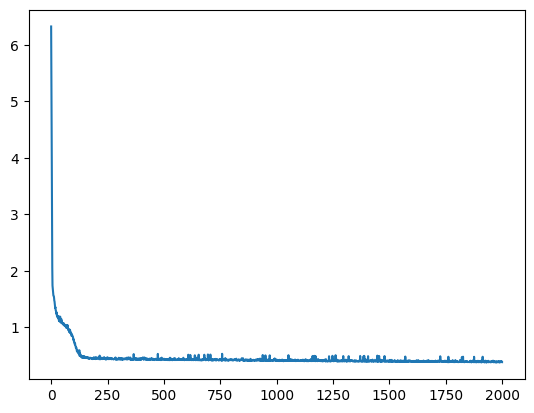

In [11]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

### Predict the Price:

In [12]:
def toTensorPred(dataset, seq_length=3):
    if len(dataset) < seq_length:
        return False

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(np.array(dataset).reshape(-1,1)).flatten()

    return scaled[-seq_length:], scaler



In [15]:
2001 + len([2001,2002,2003])

2004

In [59]:
def inflation_value(i):
    return math.pow((1+0.03), i)

def predict_end_year(input_sequence,start_year, end_year):
    start_year_a = start_year + len(input_sequence) - 1
    inp_seq, sc = toTensorPred(input_sequence)

    values = []
    
    for i in range(end_year - start_year_a):
        inp = torch.tensor(inp_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
        with torch.no_grad():
            pred = model(inp)
        pred_value = pred.item()
        inf = inflation_value(i)
        values.append(sc.inverse_transform([[pred_value]])[0][0] * inf)
        inp_seq = np.append(inp_seq[1:],pred_value)

    return values

test = predict_end_year(Countries["Finland"][0],Countries["Finland"][1],2024)

1985
prediction with accounted inflation: 8480.247249192442
goals: 8,877


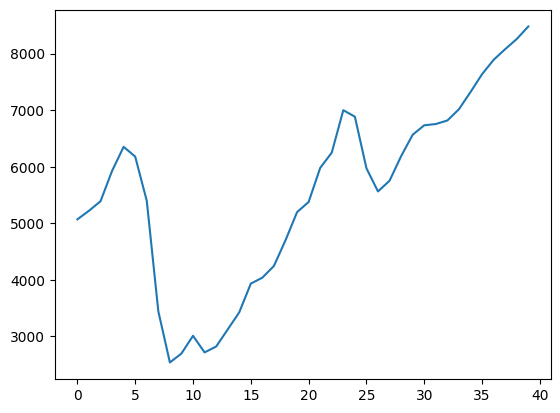

In [60]:
print(Countries["Finland"][1])
print("prediction with accounted inflation: " + str(test[-1]))
print("goals: 8,877")
plt.plot(Countries["Finland"][0] + test)
plt.show()